In [118]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')

from astroLuSt.preprocessing import (
    binning, dataseries_manipulation, pdm, psearch_saha, sigmaclipping
)

import importlib
importlib.reload(binning)
importlib.reload(dataseries_manipulation)
importlib.reload(pdm)
importlib.reload(psearch_saha)
importlib.reload(sigmaclipping)

<module 'astroLuSt.preprocessing.sigmaclipping' from 'c:\\Users\\lukas\\Documents\\GitHub\\astroLuSt\\demos\\..\\astroLuSt\\preprocessing\\sigmaclipping.py'>

# Generate (periodic) time-series

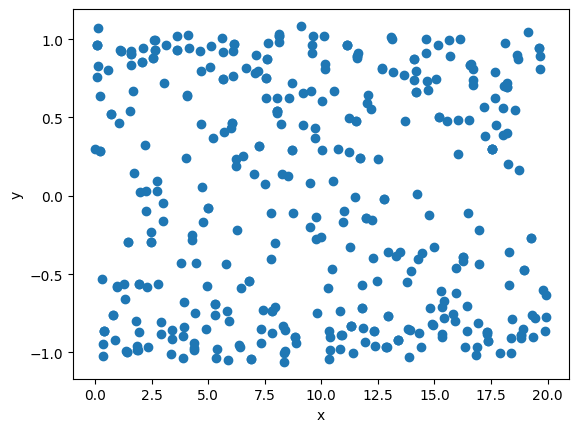

In [119]:
p = 0.5
x = np.linspace(0,20,1000)
x += np.random.normal(size=x.shape)*0.05
y = np.sin(x*2*np.pi/0.5)  + np.random.normal(size=x.shape)*0.05

#randomly sample from x and y
randidxs = np.random.choice(np.arange(0, x.shape[0], 1), size=400)

x = x[randidxs]
y = y[randidxs]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x, y)

ax1.set_xlabel('x')
ax1.set_ylabel('y')
plt.show()


# Period Determination

## Phase Dispersion Minimization

PDM(
    period_start=0.1,
    period_stop=1.4,
    nperiods=100,
    trial_periods=None,
    n_retries=5,
    nperiods_retry=50,
    retry_range=0.1,
    tolerance_expression=*1.01,
    tolerance_decay=0.99,
    breakloop=False,
    variance_mode=interval,
    sort_output_by=periods,
    normalize=False,
    n_jobs=1,
    verbose=3,
    binning_kwargs={'nintervals': 30},
)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

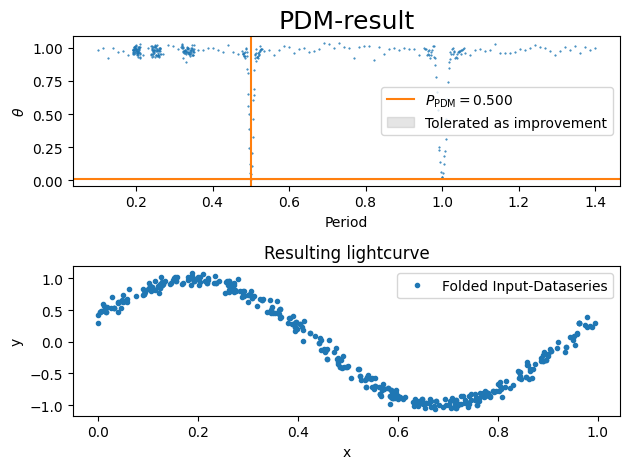

In [120]:


pdm_est = pdm.PDM(
    period_start=0.1, period_stop=1.4, nperiods=100,
    # trial_periods=np.array([0.5, 1, 0.333]),
    n_retries=5,
    tolerance_expression='*1.01',
    tolerance_decay=0.99,
    nperiods_retry=50,
    breakloop=False,
    n_jobs=1,
    verbose=3,
    binning_kwargs={'nintervals':30}
)

print(pdm_est)

pdm_est.fit_predict(x, y)
# pdm.fit(x, y)

fig, axs = pdm_est.plot_result()

## PSearch_Saha

Hybrid period finiding algorithm as introduced in [Saha et al., 2017](https://ui.adsabs.harvard.edu/abs/2017AJ....154..231S/abstract)

In [135]:
import pandas as pd
df = pd.read_csv(r'G:\My Drive\Uni\Physik\Master\Masters Thesis_AI in astronomy\RRLyr_VSX_TESS\data\eleanor_extracted\slurm\tic65992.csv', sep=';')
df = pd.read_csv(r'G:\My Drive\Uni\Physik\Master\Masters Thesis_AI in astronomy\RRLyr_VSX_TESS\data\eleanor_extracted\slurm\tic1533189.csv', sep=';')
# df = pd.read_csv(r'G:\My Drive\Uni\Physik\Master\Masters Thesis_AI in astronomy\RRLyr_VSX_TESS\data\eleanor_extracted\slurm\tic57466.csv', sep=';')

x = df['time']
y = df['corr_flux']
for s in np.unique(df['sector']):
    y[df['sector']==s] /= np.nanmedian(y[df['sector']==s])

C:\Users\lukas\AppData\Local\Temp\ipykernel_15592\1218313697.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[df['sector']==s] /= np.nanmedian(y[df['sector']==s])


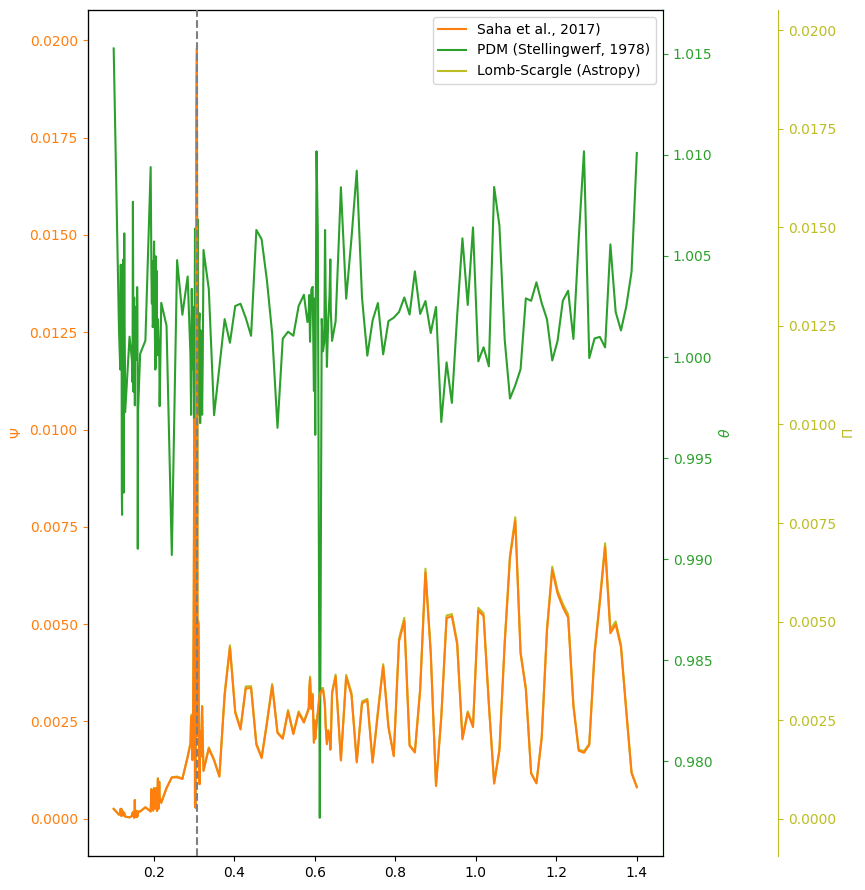

Saha 2017 result:    0.307
PDM result:          0.121
Lomb-Scargle result: 0.307


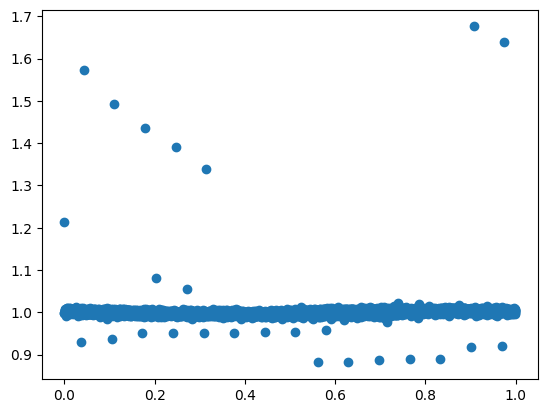

In [165]:
importlib.reload(psearch_saha)

trial_periods1 = np.linspace(0.4, 0.6, 50)
trial_periods2 = np.linspace(0.9, 1.1, 50)
trial_periods = np.append(trial_periods1, trial_periods2)
pss = psearch_saha.PSearch_Saha(
    0.1, 1.4, 100,
    # trial_periods=trial_periods,
    pdm_kwargs={'n_retries':5}#, 'nintervals':30},
)

best_period, best_phi = pss.fit_predict(x, y)#, trial_periods=trial_periods1)
fig, axs = pss.plot_result(fig_kwargs={'figsize':(9,9)})

print(f'Saha 2017 result:    {pss.best_period:.3f}')
print(f'PDM result:          {pss.best_period_pdm:.3f}')
print(f'Lomb-Scargle result: {pss.best_period_ls:.3f}')


ph, pe = dataseries_manipulation.fold(x, best_period)
plt.scatter(ph, y)

# Data Binning

## Fixed number of bins

INFO: Generated 5 bins


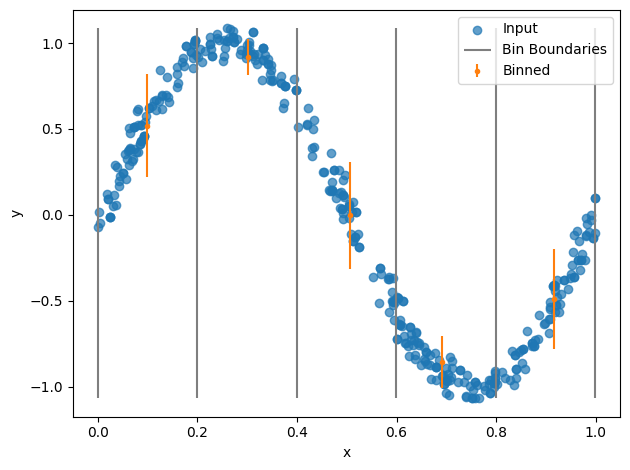

In [12]:
bng = binning.Binning(
    nintervals=5, npoints_per_interval=None,
    xmin=None, xmax=None,
    ddof=0,
    verbose=3
)

x_binned, y_binned, y_std = bng.bin_curve(
    pdm_est.best_fold_x, pdm_est.best_fold_y
)

fig, axs = bng.plot_result(
    pdm_est.best_fold_x, pdm_est.best_fold_y,
    x_binned, y_binned, y_std
)

## Fixed number of bins (fraction of dataseries length)

INFO: Generated 40 bins


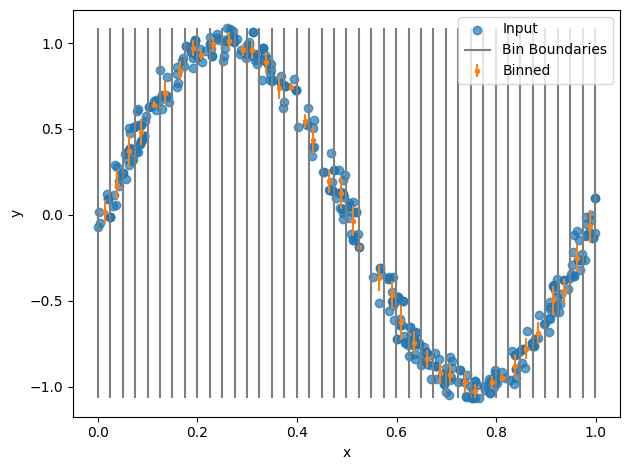

In [13]:
bng = binning.Binning(
    nintervals=0.1, npoints_per_interval=None,
    xmin=None, xmax=None,
    ddof=0,
    verbose=3
)

x_binned, y_binned, y_std = bng.bin_curve(
    pdm_est.best_fold_x, pdm_est.best_fold_y
)

fig, axs = bng.plot_result(
    pdm_est.best_fold_x, pdm_est.best_fold_y,
    x_binned, y_binned, y_std
)

## Fixed number of datapoints per bin

INFO: Generated 14 bins


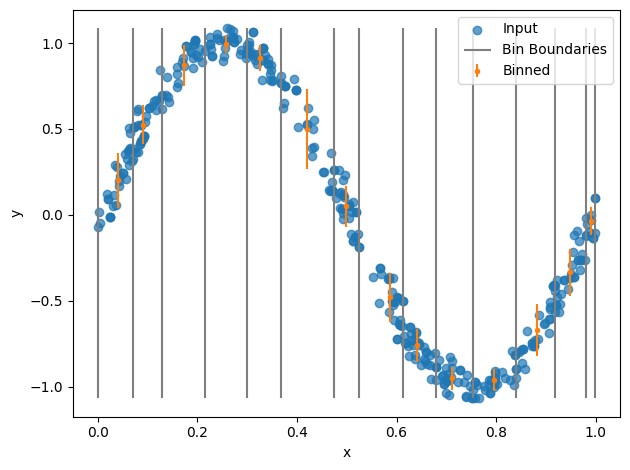

In [14]:
bng = binning.Binning(
    nintervals=5, npoints_per_interval=30,
    xmin=None, xmax=None,
    ddof=0,
    verbose=3
)

x_binned, y_binned, y_std = bng.bin_curve(
    pdm_est.best_fold_x, pdm_est.best_fold_y
)

fig, axs = bng.plot_result(
    pdm_est.best_fold_x, pdm_est.best_fold_y,
    x_binned, y_binned, y_std
)

# Sigma Clipping

INFO: Calculating mean-curve because one of 'mean_x', 'mean_y', std_y' is None!
INFO: Generated 40 bins


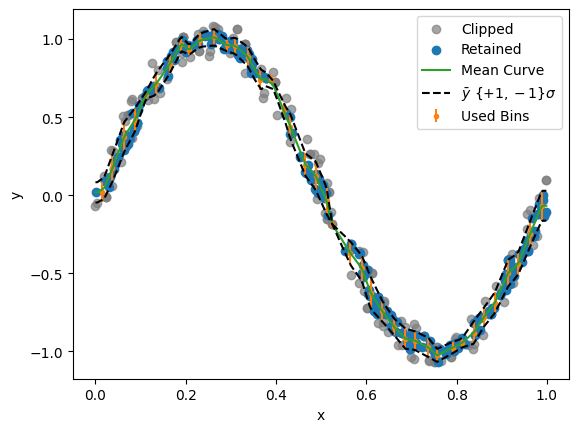

In [15]:
sigclip = sigmaclipping.SigmaClipping(
    pdm_est.best_fold_x, pdm_est.best_fold_y,
    mean_x=None, mean_y=None, std_y=None,
    sigma_bottom=1, sigma_top=1,
    verbose=3
)

clip_mask = sigclip.clip_curve()

fig, axs = sigclip.plot_result()